<a href="https://colab.research.google.com/github/francescoasaro/IGARSS21/blob/main/IGARSS21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Deep Models from Weak Labels for Water Surface Segmentation in SAR Images.



In [1]:
# env configuration
!pip install zenodo-get
!zenodo_get 5707779
!git clone https://github.com/francescoasaro/IGARSS21

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=9ed6eef64b5244de7b39d484dd2469ac3636aa6c1e4b78793759cee0d370456a
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [80]:
# imports
import random
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('./IGARSS21')
from model import  BaselineUnet4

In [156]:
# commodity functions

def get_random_sample(samples:list, device = 'cpu'):
  '''
  Gets a random sample from the test data and prepares it for inference.
  '''
  idx = random.choice(range(0,len(samples)))
  input = samples[idx][0]
  tensor = torch.tensor(input)
  tensor = tensor.to(device)
  tensor = tensor.unsqueeze(0)
  
  return tensor, samples[idx]


def get_prediction(tensor:torch.tensor, model):
  
  softmax = nn.Softmax2d()
  logits = model(tensor)
  prediction = softmax(logits).squeeze(0)
  prediction = torch.argmax(prediction, axis=0)
  prediction = prediction.detach().cpu().numpy()

  return prediction


def plot_prediction(sample:tuple,prediction:np.array, nodata_value = None):
  
  fig, ax = plt.subplots(nrows=1,ncols=4,figsize=(20,20))
  ax[0].imshow(sample[0][0,:,:],vmin=0,vmax=10,cmap='gray')
  ax[0].set_title('VH polarization intensity',fontsize=20)
  ax[1].imshow(sample[0][1,:,:],vmin=0,vmax=25,cmap='gray')
  ax[1].set_title('VV polarization intensity', fontsize=20)
  label = np.float32(sample[1])
  prediction = np.float32(prediction)
  if nodata_value:
    mask = (label== nodata_value)
    label[mask] = np.nan
    prediction[mask] = np.nan
  ax[2].imshow(label,vmin=0,vmax=1,cmap='Blues')
  ax[2].set_title('Label', fontsize=20)
  ax[3].imshow(prediction,vmin=0,vmax=1,cmap='Blues')
  ax[3].set_title('Prediction', fontsize=20)

  return

In [8]:
# load examples
examples = np.load('./IGARSS21_samples.npy',allow_pickle = True)

In [75]:
# check if GPU is available and load model
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = "cpu"

model = BaselineUnet4(2,2)  
model = nn.DataParallel(model)
checkpoint = torch.load('./IGARSS21_weights.pth',map_location = device)
model.load_state_dict(checkpoint) 
model.eval()  
model.to(device)

DataParallel(
  (module): BaselineUnet4(
    (conv_encode1): Sequential(
      (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (conv_maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_encode2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (conv_maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_encode3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (conv_maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

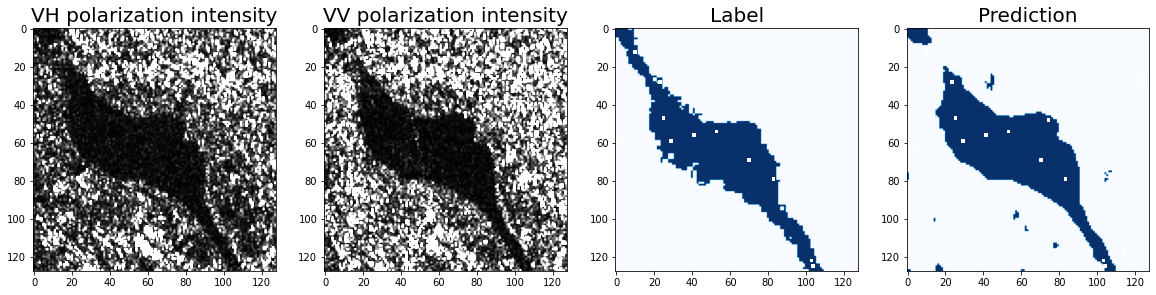

In [160]:
# inference
tensor,sample = get_random_sample(examples,device = device)
pred = get_prediction(tensor, model)
plot_prediction(sample,pred, nodata_value = 255)